In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
np.random.seed(0)
tf.random.set_seed(0)

In [4]:
num_samples = 1000
train = 0.8
test = 0.1
validation = 0.1

In [5]:
x = np.linspace(0, 2*np.pi - 1e-6, num_samples)[:, np.newaxis]
np.random.shuffle(x)
x_train, x_test, x_valid = x[:800, :], x[800:900, :], x[900:, :]

# Generate target sine values (y-values)
y_train = tf.math.sin(x_train)
y_test = tf.math.sin(x_test)
y_valid = tf.math.sin(x_valid)

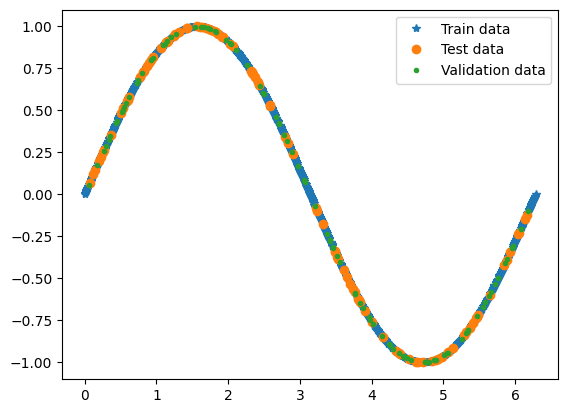

In [6]:
plt.plot(x_train, y_train, '*', label="Train data")
plt.plot(x_test, y_test, 'o', label="Test data")
plt.plot(x_valid, y_valid, '.', label="Validation data")
plt.legend()
plt.show()

In [7]:
class ClassicNet(tf.keras.Model):
    def __init__(self):
        super(ClassicNet, self).__init__()
        self.hidden = keras.layers.Dense(128, activation='relu')
        self.hidden2 = keras.layers.Dense(256, activation='relu')
        self.hidden3 = keras.layers.Dense(128, activation='relu')
        self.output_layer = keras.layers.Dense(1)

    def call(self, x):
        x = self.hidden(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.output_layer(x)
        return x

In [8]:
c_model = ClassicNet()
c_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=["accuracy"],)

In [9]:
c_history = c_model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=40, verbose=2)

Epoch 1/40
25/25 - 2s - 80ms/step - accuracy: 0.0012 - loss: 0.4675 - val_accuracy: 0.0000e+00 - val_loss: 0.3214
Epoch 2/40
25/25 - 0s - 5ms/step - accuracy: 0.0012 - loss: 0.2925 - val_accuracy: 0.0000e+00 - val_loss: 0.1807
Epoch 3/40
25/25 - 0s - 5ms/step - accuracy: 0.0012 - loss: 0.1518 - val_accuracy: 0.0000e+00 - val_loss: 0.1125
Epoch 4/40
25/25 - 0s - 5ms/step - accuracy: 0.0012 - loss: 0.1025 - val_accuracy: 0.0000e+00 - val_loss: 0.0877
Epoch 5/40
25/25 - 0s - 5ms/step - accuracy: 0.0012 - loss: 0.0906 - val_accuracy: 0.0000e+00 - val_loss: 0.0761
Epoch 6/40
25/25 - 0s - 5ms/step - accuracy: 0.0012 - loss: 0.0829 - val_accuracy: 0.0000e+00 - val_loss: 0.0681
Epoch 7/40
25/25 - 0s - 6ms/step - accuracy: 0.0012 - loss: 0.0763 - val_accuracy: 0.0000e+00 - val_loss: 0.0611
Epoch 8/40
25/25 - 0s - 6ms/step - accuracy: 0.0012 - loss: 0.0705 - val_accuracy: 0.0000e+00 - val_loss: 0.0549
Epoch 9/40
25/25 - 0s - 5ms/step - accuracy: 0.0012 - loss: 0.0650 - val_accuracy: 0.0000e+00 -

## Quantum Circuit

In [10]:
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RY_layer(w):
    qml.RY(w[0], wires=0)
    qml.RY(w[1], wires=1)
    qml.RY(w[2], wires=2)
    qml.RY(w[3], wires=3)

def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [11]:
dev = qml.device("default.qubit", wires=4)

In [12]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """
    q_weights = tf.reshape(q_weights_flat, (6,4))
    H_layer(4)
    RY_layer(q_input_features)
    
    entangling_layer(4)
    RY_layer(q_weights[0])

    entangling_layer(4)
    RY_layer(q_weights[1])

    entangling_layer(4)
    RY_layer(q_weights[2])

    entangling_layer(4)
    RY_layer(q_weights[3])

    entangling_layer(4)
    RY_layer(q_weights[4])

    entangling_layer(4)
    RY_layer(q_weights[5])
    
    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(4)]
    return tuple(exp_vals)

In [13]:
class HybridNet(tf.keras.Model):
    def __init__(self):
        super(HybridNet, self).__init__()
        self.hidden = keras.layers.Dense(128, activation='relu')
        self.hidden2 = keras.layers.Dense(256, activation='relu')
        self.hidden3 = keras.layers.Dense(128, activation='relu')
        self.convertor = keras.layers.Dense(4, activation='relu')
        self.q_params = tf.Variable(0.01 * tf.random.normal([6 * 4]))
        self.output_layer = keras.layers.Dense(1)

    def call(self, x):
        x = self.hidden(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.convertor(x)

        q_out = tf.zeros((0, 4), dtype=tf.float64)

        q_out_elem = tf.concat([quantum_net(x[0], self.q_params)], axis=1)
        q_out = tf.concat([q_out, tf.expand_dims(q_out_elem, axis=0)], axis=0)

        q_out_elem = tf.concat([quantum_net(x[1], self.q_params)], axis=1)
        q_out = tf.concat([q_out, tf.expand_dims(q_out_elem, axis=0)], axis=0)

        q_out_elem = tf.concat([quantum_net(x[2], self.q_params)], axis=1)
        q_out = tf.concat([q_out, tf.expand_dims(q_out_elem, axis=0)], axis=0)

        q_out_elem = tf.concat([quantum_net(x[3], self.q_params)], axis=1)
        q_out = tf.concat([q_out, tf.expand_dims(q_out_elem, axis=0)], axis=0)
        x = self.output_layer(q_out)
        return x

In [14]:
h_model = HybridNet()
h_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=["accuracy"],)

In [15]:
h_history = h_model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=40, batch_size=4, verbose=2)

Epoch 1/40
200/200 - 43s - 214ms/step - accuracy: 0.0012 - loss: 0.2888 - val_accuracy: 0.0000e+00 - val_loss: 0.1122
Epoch 2/40
200/200 - 2s - 8ms/step - accuracy: 0.0012 - loss: 0.0720 - val_accuracy: 0.0000e+00 - val_loss: 0.0538
Epoch 3/40
200/200 - 2s - 8ms/step - accuracy: 0.0012 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0361
Epoch 4/40
200/200 - 2s - 8ms/step - accuracy: 0.0012 - loss: 0.0319 - val_accuracy: 0.0000e+00 - val_loss: 0.0325
Epoch 5/40
200/200 - 2s - 8ms/step - accuracy: 0.0012 - loss: 0.0243 - val_accuracy: 0.0000e+00 - val_loss: 0.0263
Epoch 6/40
200/200 - 2s - 8ms/step - accuracy: 0.0012 - loss: 0.0178 - val_accuracy: 0.0000e+00 - val_loss: 0.0133
Epoch 7/40
200/200 - 2s - 8ms/step - accuracy: 0.0012 - loss: 0.0095 - val_accuracy: 0.0000e+00 - val_loss: 0.0131
Epoch 8/40
200/200 - 2s - 8ms/step - accuracy: 0.0012 - loss: 0.0059 - val_accuracy: 0.0000e+00 - val_loss: 0.0047
Epoch 9/40
200/200 - 2s - 8ms/step - accuracy: 0.0012 - loss: 0.0025 - val_ac

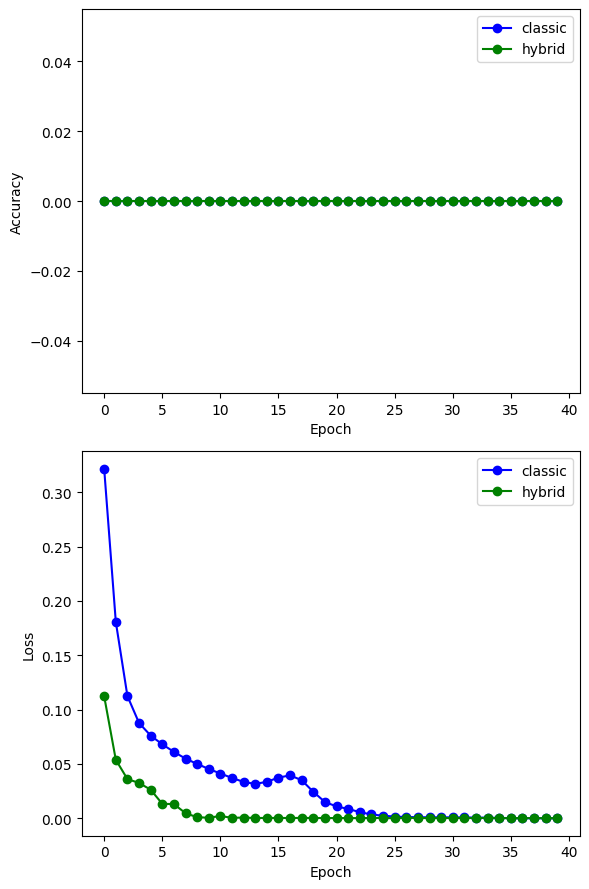

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(c_history.history["val_accuracy"], "-ob", label="classic")
ax1.plot(h_history.history["val_accuracy"], "-og", label="hybrid")
ax1.set_ylabel("Accuracy")
# ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(c_history.history["val_loss"], "-ob", label="classic")
ax2.plot(h_history.history["val_loss"], "-og", label="hybrid")
ax2.set_ylabel("Loss")
# ax2.set_ylim(top=1)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


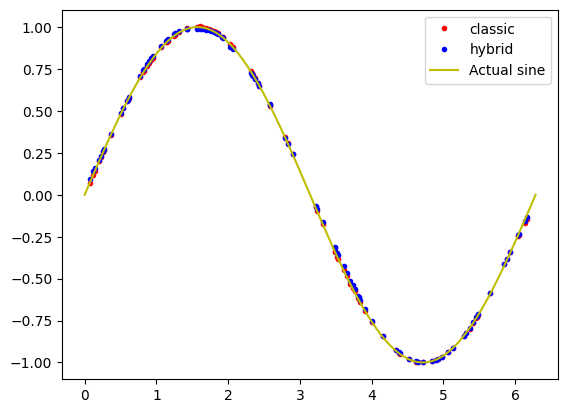

In [17]:
x_new = np.linspace(0, 2 * np.pi, 100)

y_c_predicted = c_model.predict(x_test)

x_reshaped = x_test.reshape(25, 4)
y_h_predicted = np.array([])
for chunk in x_reshaped:
    chunk = chunk.reshape(-1, 1)
    y_h = h_model.predict(chunk)
    y_h_predicted = np.concatenate((y_h_predicted, y_h.flatten()))

#plt.plot(x_train, y_train, 'o', label="Training data")
plt.plot(x_test, y_c_predicted, '.r', label="classic")
plt.plot(x_test, y_h_predicted, '.b', label="hybrid")
plt.plot(x_new,  np.sin(x_new), '-y', label="Actual sine")
plt.legend()
plt.show()